# Cargo Holds: Clean or Dirty
___

### Background

Owning and operating a dry bulk vessel is challenging.  Earning a profit on any voyage is not a given even with careful calculations, knowledge, and a solid strategy.  Not only only are these profit margins getting thinner but they are absorbing more and more risk to earn them.  One of those risks is fixing a cargo that the vessel's cargo holds might not be ready for on time.  This leads to costly delays, tens of thousands of dollars in time, additional cleaning costs, and damage to a carriers reputation with a charterer.
___

### Problem Statement

Vessel operators have to decide a vessel's next cargo well ahead of knowing the condition her holds will be in when the vessel arrives to load the cargo.  The operator may have some knowledge to this problem, such as: the vessel's cargo history, overall condition of her holds coatings from the time of hire, and possibly the crew's experience and capability preparing the vessel's holds.  However, the determination of the suitability of her holds is left to an inspector's review of her holds before loading that the vessel operator does not have knowledge of in advance.  This uncertainty creates a knowledge gap in the decision making.

Can vessel operators use an image classification model to quickly get an answer to improve their confidence in determining the cleanliness of the cargo holds coming from a data driven decision instead of relying on intuition?

___

### Solution

This model has shown the potential for differentiating between a clean and dirty cargo hold.  The CNN model, trained on hundreds of images of clean and dirty cargo holds.  The model shows promise to perform this task well and possibly segment the level of cleanliness against the differnt levels of clean.  This will be achieved by retraining the model on pictures of vessels that have passed inspections of interest.  With this tool the vessel operator can quickly determine the likliehood, not a guarantee, that the vessel's holds will be accepted for the intended cargo.
___

### Evidence

This project lays out the steps and strategy taken to produce a model of distinguishing between a clean and dirty cargo hold.  The model has been measured for accuracy with the goal of reducing false positives.  In the problem of classifying a hold as clean or dirty, clean is a positive outcome and dirty is a negative outcome.  Therefore a false positive, an instance where the model incorrectly predicts the holds are clean, are limited. 
___

### Engage

The model is only as good as the images it is provided.  If the images provided omit trouble spots or are not providing enough detail the results will be misleading.  The tool can be tried by submitting an image to the following link.

___

In [1]:
import os
import shutil

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, smart_resize

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

## Data
___

There were no publicly available datasets found online.  The dataset for this problem had to be collected.  From there it will be explored, pre-processed, and organized before being modeled.
___

![Data Directory](../assets/Data_Directory.jpg)


___
#### Data Collection

The data was provided by Nippon Paint Marine, Three Ds Marine Inc, and Seachios Marine Services.  Three Ds Marine Inc is a cargo hold cleaning company based out of the Columbia River.  Seachios Marine Services is based out of Santos Brazil.  They were chosen, as not only do they do great work, as they are hired to prepare vessels for some of the more challenging cargo cleanliness standards to meet.  

The Columbia River is one of the top grain exporteres in the world (behind the Mississippi River and Parana River) while Santos is the main port for grain exports in Brazil. Vessels need to be clean in order to transport grains. While this cleanliness standard is high, it is not the highest as some cargos need "hospital clean" cargo holds. These cargos are extremely sensitive to contamination, such as soda ash and alumina. The Columbia River is one of the largest exporters of soda ash which is used in the production of glass, detergents, batteries amongst other uses.  While Brazil exports large amounts of alumina used in the production of aluminum, ceramics, plastics, paints, and cosmetics. 

Nippon Marine Paint provided some images of freshly painted cargo holds.  Typically cargo holds that have been freshly painted in dry dock do not hire cleaning gangs.  These images are being added to capture this perspective.

Due to their combination of quality and storage size, jpg images are preferred for this project.
___

In [2]:
# Collect list of sources and image names
sources_path = '../data/sources/'
sources_directory = {}

for directory in os.listdir(sources_path):
    sources_directory[directory] = [i for i in os.listdir(sources_path + directory)]
    
# Create a dataframe to track image files
rows = []
for k, v in sources_directory.items():
    for value in v:
        rows.append([k, value])
images_df = pd.DataFrame(rows, columns=['source', 'original_name'])
images_df.head()

,source,original_name
0,Nippon Paint Marine,cargo hold 1.jpg
1,Nippon Paint Marine,cargo hold 2.jpg
2,Nippon Paint Marine,cargo hold 3.jpg
3,Nippon Paint Marine,cargo hold 4.jpg
4,Seachios,038772db-641a-4b17-bda8-52d5304d3fa4.jpg


In [3]:
# Collect list of image types and image names
collected_path = '../data/collected'
raw_images = [i for i in os.listdir(collected_path)]

# Count of different types
image_types = []
for image in raw_images:
    file_types = image.rsplit('.', 1)[-1].lower()
    image_types.append(file_types)
image_types_count = pd.Series(image_types).value_counts()
print()
print(f'There are {len(raw_images)} images in the dataset. \nThey are distributed:\n {image_types_count}:')


There are 834 images in the dataset. 
They are distributed:
 jpg     787
jpeg     47
Name: count, dtype: int64:


___
#### Data Classification
Images are manually classified as dirty or clean after visual review.  The dataframe is updated to reflection the classification.
___

In [4]:
# Update dataframe to indicate image class
clean_path = '../data/classified/clean/'
clean_images = [i for i in os.listdir(clean_path)]

dirty_path = '../data/classified/dirty/'
dirty_images = [i for i in os.listdir(dirty_path)]

not_used = []
for image in raw_images:
    if image not in clean_images and image not in dirty_images:
        not_used.append(image)

images_df['class'] = images_df['original_name'].apply(
    lambda image: 'clean' if image in clean_images 
    else ('dirty' if image in dirty_images else 'not_used'))

images_df['class'].value_counts()

class
dirty       551
clean       279
not_used      5
Name: count, dtype: int64

In [5]:
# Checked not used files as not impactful for current intention
not_used

['Alumina+in+a+cargo+hold+well+prepared.jpg',
 'c67ab26e-f3fe-41b6-9d21-9fcca2e4e9c1.jpg',
 'image12.jpg',
 'painting+services+hull+ship.jpg']

___
#### Data Exploration

The initial dataset contains 834 images.  It was straightforward to classify the holds as clean or dirty working with a dataset of this size.  It was also quickly noticeable that this dataset is imbalanced, with 94 clean cargo holds and 466 dirty cargo holds.  In the real world, this data should be perfectly balanced as a cargo hold is either clean or dirty for the purposes of this problem.  The working process for determining cargo hold cleanlieness would start with dirty cargo holds and end with clean holds.

From this initial classification of the dataset, the images will be explored further to get a better understanding viusally of the data, the types of issues that render a cargo hold dirty, and the distribution of the size of images.
___

In [6]:
# Size of classes in the dataset
num_clean = len([i for i in os.listdir('../data/classified/clean/')])
num_dirty = len([i for i in os.listdir('../data/classified/dirty/')])
num_clean, num_dirty

(279, 551)

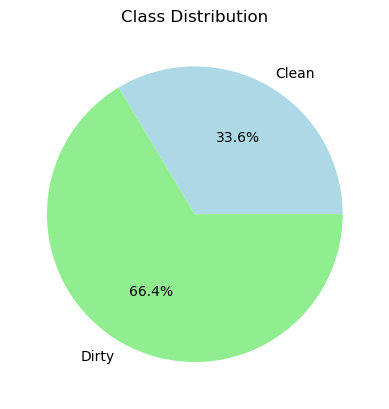

In [7]:
# Pie chart with class distribution
fig, ax = plt.subplots()
ax.pie(x=[num_clean, num_dirty], labels=['Clean', 'Dirty'], colors=['lightblue', 'lightgreen'], autopct='%1.1f%%')
ax.set_title('Class Distribution')
plt.savefig('../assets/Class_Distribution.jpg')
plt.show();

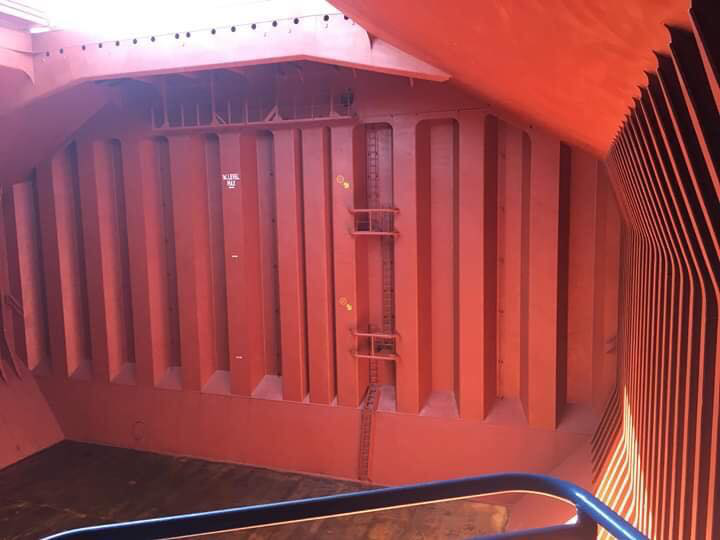

In [8]:
# Review clean cargo hold image
clean1 = load_img('../data/classified/clean/47681173_2008763662504219_1873423245131120640_n.jpg')
clean2 = load_img('../data/classified/clean/48418327_2026951410685444_6927397904709582848_n.jpg')
clean1

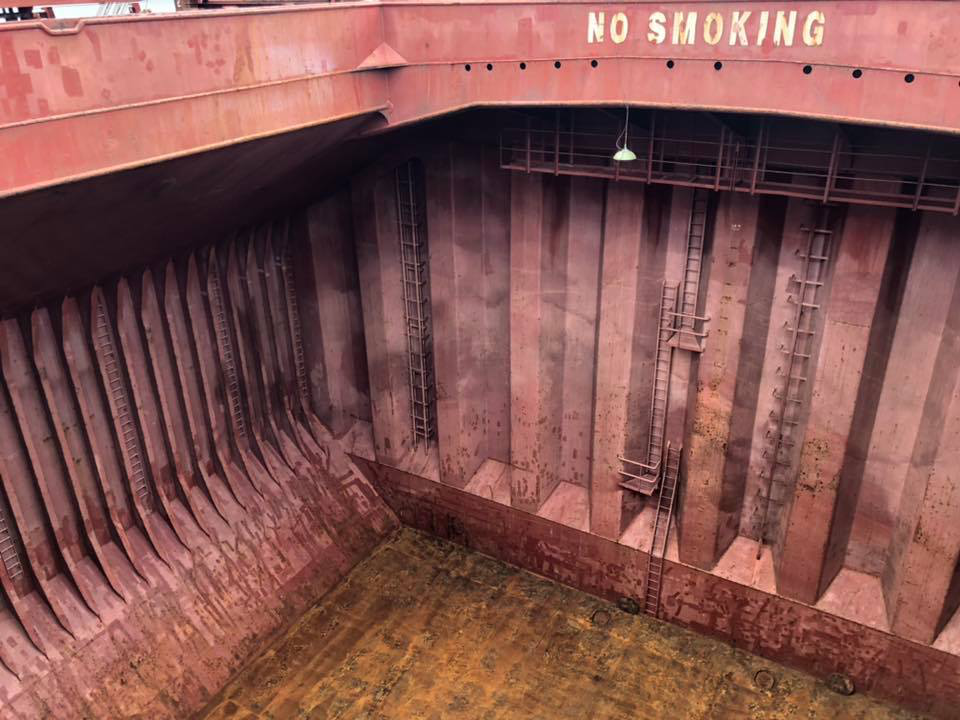

In [9]:
# Review dirty cargo hold image
dirty1 = load_img('../data/classified/dirty/46706053_1983209351726317_6755771672986386432_n.jpg')
dirty2 = load_img('../data/classified/dirty/46491446_1983209548392964_3471892652591415296_n.jpg')
dirty1

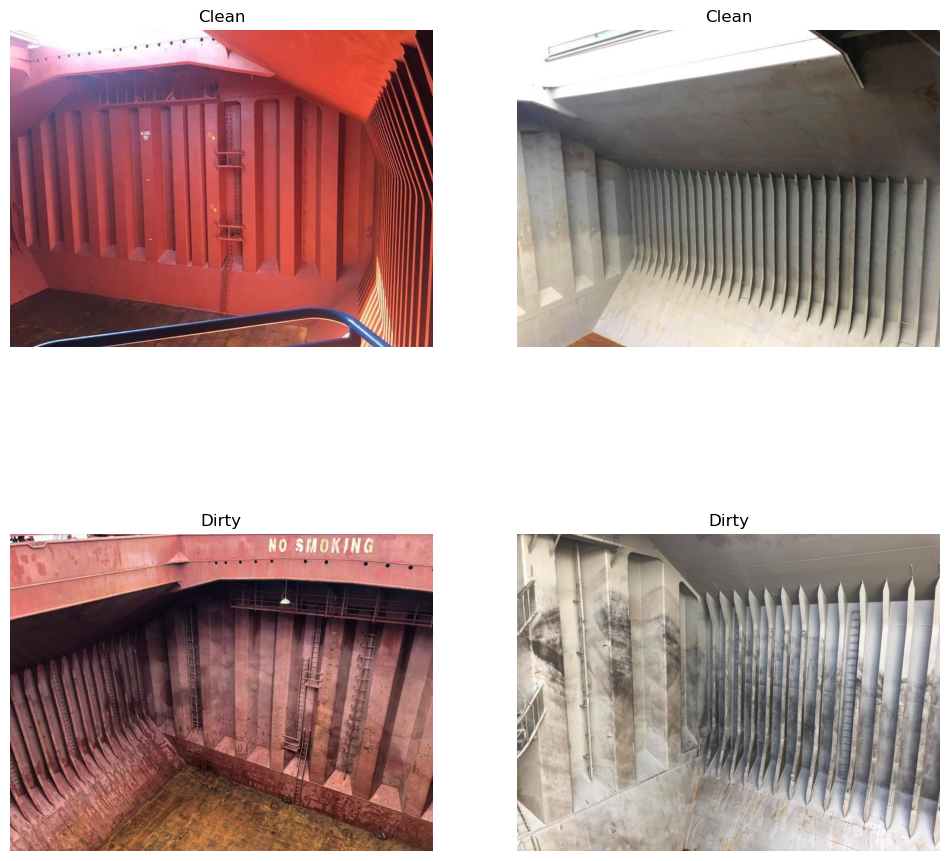

In [10]:
# Comparing clean to dirty with similar color hold coatings

fig, axes = plt.subplots(2, 2, figsize=(12,12))

axes[0, 0].imshow(clean1)
axes[0, 0].set_title('Clean')
axes[0, 0].axis('off')

axes[0, 1].imshow(clean2)
axes[0, 1].set_title('Clean')
axes[0, 1].axis('off')

axes[1, 0].imshow(dirty1)
axes[1, 0].set_title('Dirty')
axes[1, 0].axis('off')

axes[1, 1].imshow(dirty2)
axes[1, 1].set_title('Dirty')
axes[1, 1].axis('off')

plt.show;

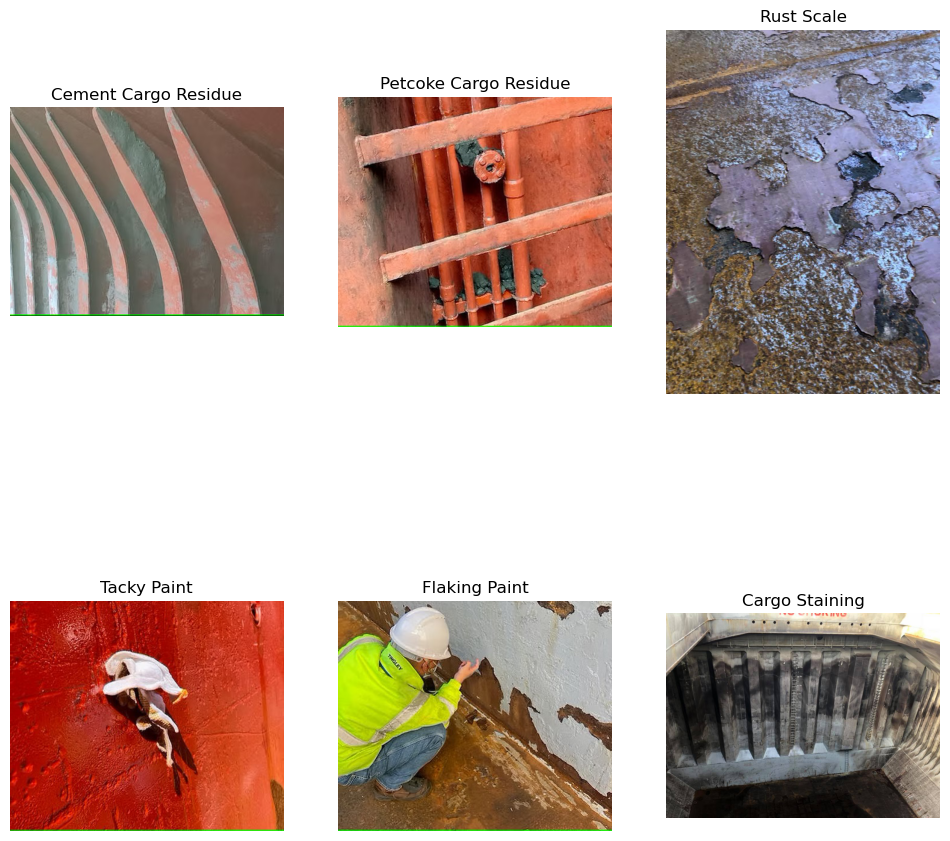

In [11]:
# different types of issues

cargoresidue = load_img('../data/classified/dirty/12c943_1ff40351da324d869a7f3b4c40d1b3e2~mv2.jpg')
cargoresidue2 = load_img('../data/classified/dirty/12c943_2fa04463d9254f2b8baf668e14de169a~mv2.jpg')
rustscale = load_img('../data/classified/dirty/66714988_2345934515453797_4846150941700784128_n.jpg')
tackypaint = load_img('../data/classified/dirty/12c943_e53efdefc0294acaa30e0a394f266436~mv2.jpg')
flakingpaint = load_img('../data/classified/dirty/12c943_efd8bd3332474e328fdbcef5cb7d2f46~mv2.jpg')
staining = load_img('../data/classified/dirty/46675044_1983208488393070_2248909549803143168_n.jpg')

fig, axes = plt.subplots(2, 3, figsize=(12,12))

axes[0, 0].imshow(cargoresidue)
axes[0, 0].set_title('Cement Cargo Residue')
axes[0, 0].axis('off')

axes[0, 1].imshow(cargoresidue2)
axes[0, 1].set_title('Petcoke Cargo Residue')
axes[0, 1].axis('off')

axes[0, 2].imshow(rustscale)
axes[0, 2].set_title('Rust Scale')
axes[0, 2].axis('off')

axes[1, 0].imshow(tackypaint)
axes[1, 0].set_title('Tacky Paint')
axes[1, 0].axis('off')

axes[1, 1].imshow(flakingpaint)
axes[1, 1].set_title('Flaking Paint')
axes[1, 1].axis('off')

axes[1, 2].imshow(staining)
axes[1, 2].set_title('Cargo Staining')
axes[1, 2].axis('off')

plt.show;

___
#### Image size
To understand the dataset, the distribution of image sizes is important.  As camera technology has improved, images are capturing more and more info.  As such, size and resolutions have improved.

This should be reviewed in the future to consider how the image size distribution is affecting model performance.  As a consideration for future data to collect.
___

In [12]:
# gather image size ranges
clean_path = '../data/classified/clean/'
dirty_path = '../data/classified/dirty/'

clean_sizes = [load_img(os.path.join(clean_path, i)).size for i in os.listdir(clean_path)]
dirty_sizes = [load_img(os.path.join(dirty_path, i)).size for i in os.listdir(dirty_path)]

max(clean_sizes), min(clean_sizes), max(dirty_sizes), min(dirty_sizes)

((4032, 3024), (300, 224), (4032, 3024), (300, 225))

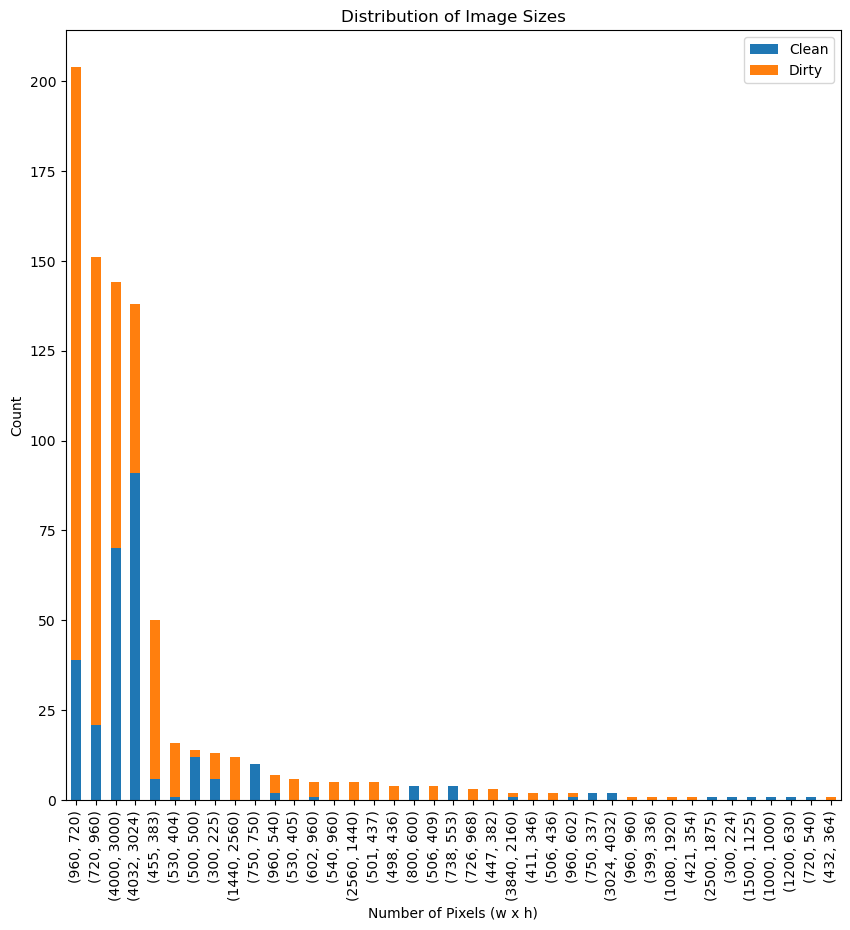

In [13]:
# Review image size distribution
clean_sizes_dist = pd.Series(clean_sizes).value_counts()
dirty_sizes_dist = pd.Series(dirty_sizes).value_counts() 

size_dist = pd.concat([clean_sizes_dist, dirty_sizes_dist], axis=1)
size_dist.columns = ['Clean', 'Dirty']
size_dist.fillna(0, inplace=True)
size_dist['Total'] = size_dist['Clean'] + size_dist['Dirty']
size_dist_sorted = size_dist.sort_values('Total', ascending=False)

# plotting distributions
ax = size_dist_sorted[['Clean', 'Dirty']].plot(figsize=(10,10), kind='bar', stacked=True)
ax.set_title('Distribution of Image Sizes')
ax.set_ylabel('Count')
ax.set_xlabel('Number of Pixels (w x h)')
plt.show();

In [14]:
# Saving data collection and exploratuion to a csv
images_df.to_csv('../data/data_eda.csv', index=False)